## Imports

In [1]:
from gurobipy import *

import numpy as np
from numpy.matlib import repmat
import scipy as sp
import matplotlib.pyplot as plt
import scipy.io as sio

%matplotlib inline

#### Problem statement

Let us determine some variables to formalize our problem.
$$
F=\left\{f_i,~i=1,\dots,m\right\}~-~\text{facilities},\\
C=\left\{c_j,~j=1,\dots,n\right\}~-~\text{clients},\\
K=\left\{k_{ij}\right\},k_{ij}~-~\text{cost of serving}~j_{th}~\text{client in}~i_{th}~\text{facility}, \\
L=\left\{l_i\right\},~l_i~-~\text{cost of}~i_{th}~\text{facility opening}, \\
S=\left\{s_i\right\},~s_i~-~\text{maximal capacity of}~i_{th}~\text{facility}, \\
y_i = \begin{cases} 0,~i_{th}~\text{facility is closed}\\1,~i_{th}~\text{facility is opened} \end{cases},\\
x_{ij} = \begin{cases} 0,~j_{th}~\text{client is not served in}~i_{th}~\text{facility}\\1,~j_{th}~\text{client is served in}~i_{th}~\text{facility} \end{cases}.
$$
Our problem will look like:
$$
\sum_{i=1}^m y_i l_i + \sum_{i=1}^m \sum_{j=1}^n x_{ij} k_{ij} \rightarrow \min_{x,y}, \\
\sum_{i=1}^m x_{ij} = 1,~j=1,\dots,n, \\
\sum_{j=1}^n x_{ij} \leq s_i y_i.
$$

**Problem 1:** *Capacitated facility location.* 

You need to solve a *capacitated facility location* problem. There are a number of clients that can be served by a number of potential facilities. As in the case of a common (uncapacitated) facility location problem, you need to decide which facilities to open (paying the opening cost for each) and which clients to serve at each facility (paying the assignment cost). Each client must be assigned to one opened facility. In addition, you have a cap on how many clients each facility can serve. As usual, you want to minimize the costs.

Implement the following algorithms and investigate them. Use the attached script to generate the data, and to visualize the results. You are supposed to play with different configurations and sizes of the problem. Please make your report detailed (otherwise lower amount of points then indicated may be assigned).

* (2 points). Implement a **greedy algorithm** for the problem.
* (3 points). Implement **some local optimization algorithm**. Try to design powerful moves that are at the same time easy to search through. **Important:** your move should connect the whole domain, i.e. for any pair of feasible solutions, there should exist a sequence of moves from the family you design that transform one solution to the other.
* (3 points). Implement the **simulated annealing algorithm** based on the best of your local optimization algorithms. Play with the schedule and see how it affects the results. Compare with the local optimization algorithm that you base upon. Note, that if implemented correctly, simulated annealing should improve over the local optimization algorithm.

#### Data generation

In [2]:
np.random.seed(1)

C = 20 # number of clients
clients = np.random.rand(2,C) #client positions
F = 15 #number of facilities
facilities = np.random.rand(2,F)

capacities = np.ones((F,), dtype=np.int)*4 #maximum number of clients per facility

dx = repmat(clients[0,:],F,1) - repmat(facilities[0,:],C,1).transpose()
dy = repmat(clients[1,:],F,1) - repmat(facilities[1,:],C,1).transpose()

assignment_costs = np.zeros((F, C))
assignment_costs = 3*(dx*dx + dy*dy) #the assignment cost is the distance squared

opening_costs = np.ones((F,))

#### Facility location class

In [3]:
class FacilityLocation:
    
    def __init__(self, C=C, F=F, assignment_costs=assignment_costs, 
                 opening_costs=opening_costs):
        self.x = np.zeros((F, C), dtype=np.int)
        self.y = np.zeros(F, dtype=np.int)      
        
    def total_cost(self):    
        res = 0       
        for i_f in xrange(F):
            res += self.y[i_f] * opening_costs[i_f]       
        for i_f in xrange(F):
            for i_c in xrange(C):
                res += self.x[i_f][i_c] * assignment_costs[i_f][i_c]          
        return res
    
    def generate_solution(self, seed=1): 
        self.x = np.zeros((F, C), dtype=np.int)
        self.y = np.zeros(F, dtype=np.int)     
        np.random.seed(seed) 
        for i_c in xrange(C):
            i_f = np.random.randint(F)          
            while (self.x[i_f].sum() >= capacities[i_f]):
                i_f = np.random.randint(F)
            self.x[i_f][i_c] = 1
            self.y[i_f] = 1
                
    def cost_change(self, i_c, old_fac, new_fac):         
        if (self.x[new_fac].sum() == capacities[new_fac]):
            return np.inf    
        res = -assignment_costs[old_fac, i_c]
        if (self.x[old_fac].sum() == 1):
            res -= opening_costs[old_fac]
        res += assignment_costs[new_fac, i_c]
        if (self.x[new_fac].sum() == 0):
            res += opening_costs[new_fac]           
        return res
    
    def move_client(self, i_c, old_fac, new_fac):
        self.x[old_fac][i_c] = 0
        if (self.x[old_fac].sum() == 0):
            self.y[old_fac] = 0
        self.x[new_fac][i_c] = 1
        if (self.x[new_fac].sum() == 1):
            self.y[new_fac] = 1

    def greedy_algorithm(self):
        
        costs = np.copy(assignment_costs)
        self.x = np.zeros((F, C), dtype=np.int)
        self.y = np.zeros(F, dtype=np.int)
        greedy_values = np.zeros(F)
        new_C = C
  
        while (new_C > 0):

            for i_f in xrange(F):
                if (self.y[i_f] == 0):
                    max_capacity = min(capacities[i_f], new_C)
                    greedy_values[i_f] = opening_costs[i_f] + np.mean(np.sort(costs[i_f])[:max_capacity])

            chosen_facility = np.argmin(greedy_values)
            chosen_clients = np.argsort(costs[chosen_facility])[:min(capacities[i_f], new_C)]
            greedy_values[chosen_facility] = np.inf

            self.y[chosen_facility] = 1
            self.x[chosen_facility][chosen_clients] = 1
            costs[:, chosen_clients] = np.inf

            new_C = (costs[0]!=np.inf).sum()
            
    def local_search(self):
        last_cost = np.inf
        
        while (last_cost > self.total_cost()):       
            last_cost = self.total_cost()
            
            for i_c in xrange(C):
                i_f = np.argmax(self.x[:, i_c])
                best_change = 0
                target_fac = i_f
                
                for fac in xrange(F):
                    if (self.cost_change(i_c, i_f, fac) < best_change):
                        best_change = self.cost_change(i_c, i_f, fac)
                        target_fac = fac
                self.move_client(i_c, i_f, target_fac)  
                
    def simulated_annealing(self, T0=100, gamma = .99, MAX_ITER=3000):
        best_c = 0
        best_cost = np.inf
        T = T0
        
        for i in xrange(MAX_ITER):

            for i_c in xrange(C):
                i_f = np.argmax(self.x[:, i_c])
            
                fac = np.random.randint(F)
                dE = self.cost_change(i_c, i_f, fac) 
                
                if (np.exp(-dE / T) > np.random.random(1)[0]):                
                    self.move_client(i_c, i_f, fac)
                    
            T = T * gamma    
            
    def visualize(self):
        facilities_opened = [self.y[i_f] for i_f in range(F)]    
        clients_assignment = [i_f for i_f in range(F) for i_c in range(C) if self.x[i_f][i_c] != 0]

        print "Objective =", self.total_cost()
        plt.scatter(clients[0,:], clients[1,:], s=50.0, c=clients_assignment)
        plt.scatter(facilities[0,:], facilities[1,:], s=200.0, c=range(F), linewidth = [5*el for el in facilities_opened])
        plt.show()

#### Global optimum

Below is the solution that uses a mixed-integer solver (we will come to that in week 3). You can use it as a reference for small instances (for which it will give you a global optimum), and also reuse the visualization code. 

Optimize a model with 50 rows, 315 columns and 645 nonzeros
Coefficient statistics:
  Matrix range    [1e+00, 4e+00]
  Objective range [2e-04, 5e+00]
  Bounds range    [1e+00, 1e+00]
  RHS range       [1e+00, 1e+00]
Found heuristic solution: objective 33.3461
Presolve time: 0.00s
Presolved: 50 rows, 315 columns, 645 nonzeros
Variable types: 0 continuous, 315 integer (315 binary)

Root relaxation: objective 6.503730e+00, 59 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.50373    0   12   33.34610    6.50373  80.5%     -    0s
H    0     0                      11.5023502    6.50373  43.5%     -    0s
H    0     0                       8.1447511    6.50373  20.1%     -    0s
     0     0    6.86502    0   26    8.14475    6.86502  15.7%     -    0s
H    0     0                       7.9698679    6.86502  13.9%     -    0s
     0     0    7.019

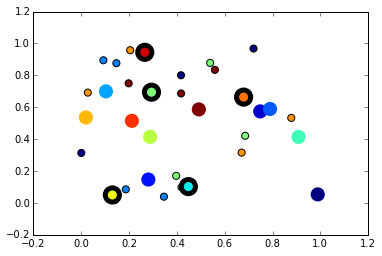

In [4]:
# create the model
m = Model("facility")

y = []
for i_f in range(F):
    y.append(m.addVar(vtype=GRB.BINARY))

x = []    
for i_f in range(F):
    x.append([])
    for i_c in range(C):
        x[i_f].append(m.addVar(vtype=GRB.BINARY))

# the objective is to minimize the total fixed and variable costs
m.modelSense = GRB.MINIMIZE

# update model to integrate new variables
m.update()

# set optimization objective - minimize sum of fixed costs
obj_summands = []
for i_f in range(F):
    obj_summands.append(opening_costs[i_f]*y[i_f])
    
for i_f in range(F):
    for i_c in range(C):
        obj_summands.append(assignment_costs[i_f][i_c]*x[i_f][i_c])

m.setObjective(quicksum(obj_summands))  

# set constraints
for i_c in range(C):
    client_constr_summands = [x[i_f][i_c] for i_f in range(F)]
    m.addConstr(sum(client_constr_summands), GRB.EQUAL, 1.0)
        
for i_f in range(F):        
    facility_constr_summands = [x[i_f][i_c] for i_c in range(C)]
    m.addConstr(sum(facility_constr_summands), GRB.LESS_EQUAL, capacities[i_f]*y[i_f])       

for i_f in range(F):        
    facility_constr_summands = [x[i_f][i_c] for i_c in range(C)]
    m.addConstr(max(facility_constr_summands), GRB.LESS_EQUAL, y[i_f])     

# optimize
  
m.optimize()

# plot the solution
facilities_opened = [y[i_f].X for i_f in range(F)]    
clients_assignment = [i_f for i_f in range(F) for i_c in range(C) if x[i_f][i_c].X != 0]
    
plt.scatter(clients[0,:], clients[1,:], s=50.0, c=clients_assignment)
plt.scatter(facilities[0,:], facilities[1,:], s=200.0, c=range(F), linewidth = [5*el for el in facilities_opened])
plt.show()

#### Greedy algoritm

The idea of our **greedy algorithm** is following. When we open new facility we try to fill it with clients to its capacity. The point is which facilities we will open. For each facility $i$ we sort clients in ascending costs order and calculate the average cost of its first $s_j$ cheapest clients. Then we sum this value with $l_i$ and choose facility with such minimal value. Then we fill this facility with clients and recalculate our data.

Objective = 9.02558149965


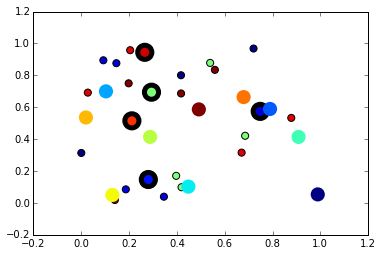

In [8]:
sol1 = FacilityLocation()
sol1.greedy_algorithm()
sol1.visualize()

#### Local search

Let us look at some feasible solution (where each client is served in some facility). If we move one client from one facility to another we will get another feasible solution. It is easy to see that such moves can give us any possible feasible solution, so they connect the whole domain. 

The idea of our **local search algorithm** is following. At first we fill some facilities with clients to get some solution of our problem. Then we choose the first client and look at all facilities we can move him to. We move him to the best possible facility (facility which will decrease our current total cost the most), choose the second client and so on. After several iterations there will be no such possible moves and we will stop.

Objective = 9.68866798368


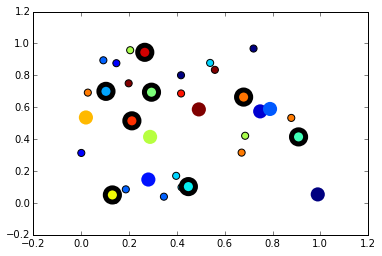

In [9]:
sol2 = FacilityLocation()
sol2.generate_solution(1)
sol2.local_search()
sol2.visualize()

#### Simulated annealing

Objective = 8.39205942967


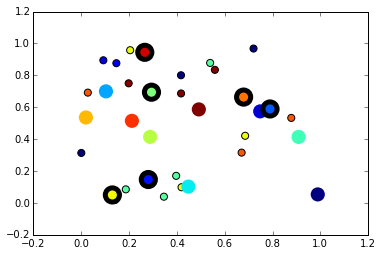

In [10]:
sol3 = FacilityLocation()
sol3.generate_solution(1)
sol3.simulated_annealing()
sol3.visualize()

#### Experiments

Now we can compare conduct of different algorithms.

In [46]:
points = 10
ls_sol = FacilityLocation()
sa_sol = FacilityLocation()
gr_sol = FacilityLocation()
ls = np.zeros(points)
sa = np.zeros(points)
global_min = np.ones(points) * 7.57

In [47]:
gr_sol.greedy_algorithm()
gr = np.ones(points) * gr_sol.total_cost()

In [48]:
for i in xrange(points):
    ls_sol.generate_solution(i)
    ls_sol.local_search()
    ls[i] = ls_sol.total_cost()

In [49]:
for i in xrange(10):
    sa_sol.generate_solution(i)
    sa_sol.simulated_annealing()
    sa[i] = sa_sol.total_cost()

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:104: RuntimeWarning: overflow encountered in exp


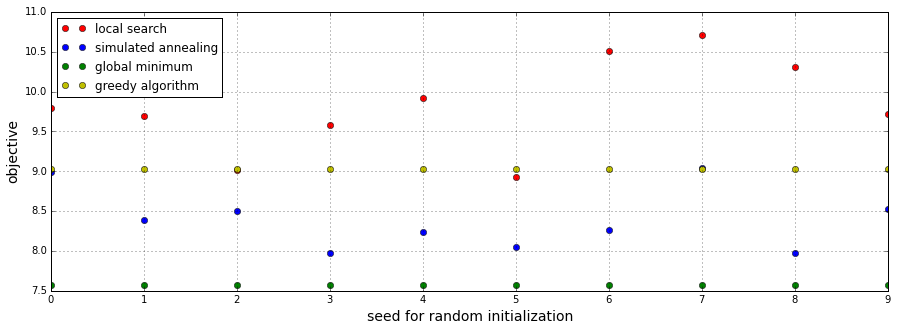

In [59]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(ls, 'ro', label = 'local search')
ax.plot(sa, 'ro', color = 'b', label = 'simulated annealing')
ax.plot(global_min, 'ro', color = 'g', label = 'global minimum')
ax.plot(gr, 'ro', color = 'y', label = 'greedy algorithm')
ax.set_xlabel('seed for random initialization', fontsize = 14)
ax.set_ylabel('objective', fontsize = 14)
ax.legend(loc = 2)
ax.grid(True)

We can see that simulated annealing finds better solutions than local search and greedy agorithm, but it is much slower. Local search algorithm often finds worse solution than greedy algorithm because it highly depends on initialization (simulated annealing too). But we can initialize local search algorithm by greedy algorithm solution and get better result. 

In [55]:
ls2 = FacilityLocation()
ls2.greedy_algorithm()
ls2.local_search()
print ls2.total_cost()

8.69482161537


________________________________________________________________________________________________________________________________

** Problem 2 **: *Optimal vehicle speed scheduling (6 points) *-- (based on an additional exercise A3.20 to Boyd and Vandenberghe). 

A vehicle (say, an airplane) travels along a fixed path of $n$ segments, between $n + 1$ waypoints labeled $0, . . . , n$. Segment $i$ starts at waypoint $i − 1$ and terminates at waypoint $i$. The vehicle starts at time $t = 0$ at waypoint $0$. It travels over each segment at a constant (nonnegative) speed; $s_i$ is the speed on segment $i$. We have lower and upper limits on the speeds: $s_{min} \leq s \leq s_{max}$. The vehicle does not stop at the waypoints; it simply proceeds to the next segment. The travel distance of segment $i$ is $d_i$ (which is positive), so the travel time over segment $i$ is $\frac{d_i}{s_i}$. We let $\tau_i$, $i = 1, \dots, n$, denote the time at which the vehicle arrives at waypoint $i$. The vehicle is required to arrive at waypoint $i$, for $i = 1, \dots, n$, between times $\tau_{min,i}$ and $\tau_{max,i}$ , which are given. The vehicle consumes fuel over segment $i$ at a rate that depends on its speed $\Phi(s_i)=a s_i^2+b s_i+c,~[\Phi]=\frac{kg}{s}$.

You are given the data $d$ (segment travel distances), $s_{min}$ and $s_{max}$ (speed bounds), $\tau_{min}$ and $\tau_{max}$ (waypoint arrival time bounds), and the the parameters $a$, $b$, and $c$ (all parameters are in $\textbf{veh_speed_sched_data.m}$). Use the dynamic programming approach to find the schedule that allows spending the minimal amount of fuel. Use matplotlib command $\textbf{step}$ to plot speed vs time for the optimal schedule. You will need to discretize some continuous variables, make sure you do it densely enough. **NB**: later in the course we will get back to this problem and attack it with a different method.


#### Problem statement

Let us formalize our problem to understand how to organize dynamic programming. Our problem can be written in the following way:
$$
\begin{cases}
\sum_{i=1}^n \Phi(s_i)(\tau_i-\tau_{i-1}) \rightarrow \min_{s_i,\tau_i} \\
(\tau_i-\tau_{i-1}) s_i = d_i, \\
\tau_{min,i} \leq \tau_i \leq \tau_{max,i}, \\
s_{min,i} \leq s_i \leq s_{max,i}, \\
i=1,\dots,n.
\end{cases}
\Rightarrow
\begin{cases}
\sum_{i=1}^n \Phi(\frac{d_i}{\tau_i - \tau_{i-1}})(\tau_i-\tau_{i-1}) \rightarrow \min_{\tau_i} \\
\tau_{min,i} \leq \tau_i \leq \tau_{max,i}, \\
s_{min,i} \leq \frac{d_i}{\tau_i - \tau_{i-1}} \leq s_{max,i}, \\
i=1,\dots,n.
\end{cases}
$$
We can organize dynamic programming in the following way. We divide each interval of time $[\tau_{min, i},\tau_{max,i}]$ by $N$ equal parts and count on each step $i = 1, \dots, n$ the minimal amount of fuel for each such part (we compare all possible ways from previous interval parts and choose the cheapest one).

#### Reading data

In [121]:
mat_contents = sio.loadmat('veh_sched_data.mat')

a = mat_contents['a'][0, 0]
b = mat_contents['b'][0, 0]
c = mat_contents['c'][0, 0]
d = mat_contents['d']
n = mat_contents['n'][0, 0]
s_min = mat_contents['smin']
s_max = mat_contents['smax']
tau_min = mat_contents['tau_min']
tau_max = mat_contents['tau_max']

#### Solution

In [122]:
def fuel(i, speed):
    return (d[i] * ((a * speed) + b + c / speed))[0]

def schedule(N = 100):
    F = np.zeros((n+1, N))
    T = np.zeros((n+1, N))
    W = np.zeros((n+1, N)).astype(int)
    t = np.zeros(n)
    
    for i in xrange(1, n+1):

        delta = (tau_max[i-1, 0] - tau_min[i-1, 0]) / N
        T[i] = np.array([tau_min[i-1, 0] + delta*x for x in xrange(N)])

        for tau_new in xrange(N):       
            F[i, tau_new] = np.inf

            for tau_old in xrange(N):     
                s = d[i-1, 0] / (T[i, tau_new]-T[i-1, tau_old])
                if (s_min[i-1, 0] <= s and s <= s_max[i-1, 0]):
                    f = fuel(i-1, s)
                    if (F[i-1, tau_old] + f < F[i, tau_new]):
                        F[i, tau_new] = F[i-1, tau_old] + f
                        W[i, tau_new] = tau_old

    cur = np.argmin(F[n])
    for i in xrange(n-1, 0, -1):
        t[i] = T[i, cur]
        cur = W[i, cur]

    s = np.zeros(n)
    s[0] = d[0, 0] / t[0]
    for i in xrange(1, n):
        s[i] = d[i, 0] / (t[i] - t[i-1])
    
    return t, s, min(F[n])

In [123]:
res = np.array([schedule(x)[2] for x in np.arange(100, 151, 5)])

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:32: RuntimeWarning: divide by zero encountered in double_scalars


In [124]:
res

array([ 2617.96014942,  2617.95620498,  2617.98550045,  2617.98507264,
        2617.95871606,  2617.95036974,  2617.94204435,  2617.92862486,
        2617.91715065,  2617.92478049,  2617.91092482])

We see that solution almost doesn't change when we increase the number of interval parts $N$ from $100$ to $150$, so the time is discretized well enough and we can use $N=100$ to find the best schedule for our problem.

In [125]:
time, speed, result = schedule()

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Minimal amount of fuel is equal to 2617.96014942


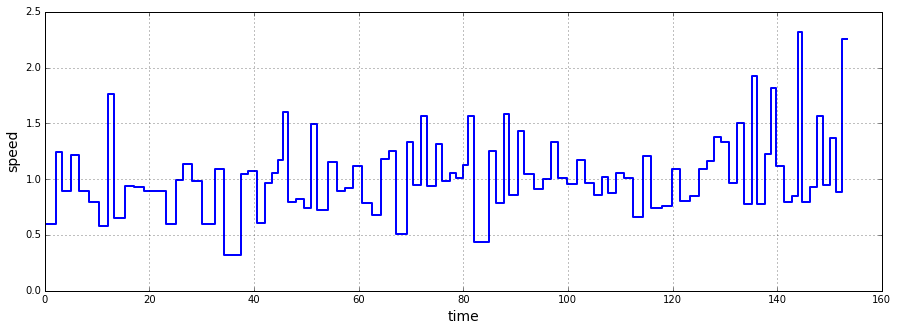

In [126]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.step(time, speed, lw=2)
ax.set_xlabel("time", fontsize=14)
ax.set_ylabel("speed", fontsize=14)
ax.grid(True)
print "Minimal amount of fuel is equal to", result